<img src="../../../images/qiskit-heading.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Wigner Functions
---
### Contributers
Russell P. Rundle$^{1,2}$, Todd Tilma$^{1,3}$, Vincent M. Dwyer$^{1,2}$, Mark J. Everitt (m.j.everitt@physics.org)$^{1}$

1 Quantum Systems Engineering Research Group, Physics Dpartment, Loughborough University, UK

2 Wolfson School, Loughborough University, UK

3 Tokyo Institute of Technology, Japan

## Introduction

In this notebook we demonstrate how to create Wigner functions by either using the full state or by measuring points in phase space. We will show the different methods which can be used by inputting an arbitrary state or just measuring the state on both the simulators and the IBM Quantum Experience.
The spin Wigner function presented here is based on work from [*T Tilma, MJ Everitt, JH Samson, WJ Munro, K Nemoto, Phys. Rev. Lett. 117, 180401*](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.117.180401) and can be calculated analytically as

$W(\boldsymbol{\Omega}) = \mathrm{Tr}\left[\hat{\rho} \; \hat{U}(\boldsymbol{\Omega}) \hat{\Pi} \hat{U}^\dagger(\boldsymbol{\Omega})\right]$

Where $\hat{U}$ is the rotation by the Euler angles and $\hat{\Pi}$ is the parity, such that

$\hat{\Pi} = \frac{1}{2} 
\begin{pmatrix}
1+\sqrt{3} & 0\\
0 & 1-\sqrt{3}
\end{pmatrix}$ 

for one qubit. The Hilbert space for a single qubit is spanned by the Euler angles where $\theta$ (the elevation) and $\phi$ (the azimuth) thus the full Wigner function for $n$ qubits is given by $2n$ degrees of freedom. 
<img src="../images/blochSphere.png", width = 300, height = 300>
When there is more than one qubit, we take the Kronecker tensor product of the $\hat{U}$s and $\hat{\Pi}$. In the following examples, various methods of extracting information from 2 entangled qubits from four degrees of freedom are shown.
These methods include taking an the equal angle slice, where we set the angles $\theta_0 = \theta_1 = \theta$ and $\phi_0 = \phi_1 = \phi$. We can also set some angles to be constant values as we plot the remaining angles against each other, an example of this can be seen when plotting the plaquettes where we set $\phi_0=\phi_1=0$ and we plot $\theta_0$ against $\theta_1$. Finally we show how we can simplify the Wigner function by just taking a 2 dimensional curve around the function, this is shown when we look at the equal angle equatorial slice where we take $\theta_i=\theta=\pi/2$ for all $\theta$s and $\phi_i=\phi$ for all values of $\phi$ where $0\leq\phi<2\pi$.
With this visualisation methods we show how these points in phase space can be measured directly by using the Wigner function tomography module and it works by using the u3 gates to rotate to points in phase space. Below is an example for measing points for a Bell-state, the first two gates create the Bell-state and the two u3 are example rotations to a point in phase space.
<img src="../images/exampleCircuit.png", width = 400>

# Wigner Functions for Arbitrary States

First we will look at the Wigner function tomography module and show how we can create the spin Wigner function on a Bloch sphere for an arbitrary state. All that is necessary is to input a density matrix or state vector for a known state and then set the desired resolution for the plot (if no resolution is set, the mesh of the sphere will default to 100x100)


In [1]:
# importing the QISKit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ

# import numpy
import numpy as np

# import tomography library
import qiskit.tools.qcvv.tomography as tomo

#visualization packages
from wigner import plot_wigner_function, plot_wigner_data

## Wigner Function for an entangled Bell-state
We begin by creating the density matrix for a Bell-state (note that the matrices and state vectors need to be created in numpy matrix format), $\left(|00\rangle+|11\rangle\right)/\sqrt{2}$, which is given by

$
\frac{1}{2}
\begin{pmatrix}
1 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
1 & 0 & 0 & 1
\end{pmatrix}
$

In [2]:
density_matrix = np.matrix([[0.5, 0, 0, 0.5],[0, 0, 0, 0],[0, 0, 0, 0],[0.5, 0, 0, 0.5]])
print(density_matrix)

[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]


This density matrix can then be put into wigner_function which plots the Bloch sphere Wigner function for the equal angle slice, i.e. where $\theta_0 = \theta_1 = \theta$ and $\phi_0 = \phi_1 = \phi$

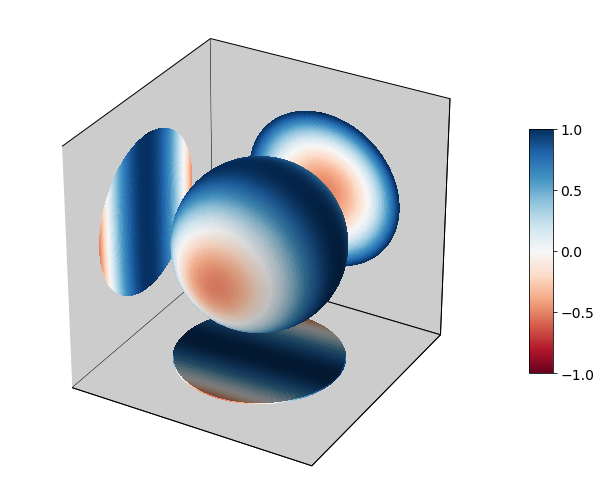

In [3]:
plot_wigner_function(density_matrix, res=200)

If it is desired to calculate the analytic expression for the Wigner function, we can import the sympy package and run the Wigner function calculations symbolically. The below code is almost identical to the code in the Wigner function tomography module but edited to work with symbolics rather than run through the points in the mesh of the sphere.

In [4]:
import sympy as sym
from sympy.physics.quantum import TensorProduct

num = int(np.log2(len(density_matrix)))
harr = sym.sqrt(3)
Delta_su2 = sym.zeros(2)   
Delta = sym.ones(1)
for qubit in range(num):
    phi = sym.Indexed('phi', qubit)
    theta = sym.Indexed('theta', qubit)
    costheta  = harr*sym.cos(2*theta)
    sintheta  = harr*sym.sin(2*theta)
    Delta_su2[0,0] =  (1+costheta)/2
    Delta_su2[0,1] = -(sym.exp(2j*phi)*sintheta)/2
    Delta_su2[1,0] = -(sym.exp(-2j*phi)*sintheta)/2
    Delta_su2[1,1] =  (1-costheta)/2
    Delta = TensorProduct(Delta,Delta_su2)
W = sym.trace(density_matrix*Delta)
print(sym.latex(W))

0.5 \left(- \frac{\sqrt{3} \cos{\left (2 {\theta}_{0} \right )}}{2} + \frac{1}{2}\right) \left(- \frac{\sqrt{3} \cos{\left (2 {\theta}_{1} \right )}}{2} + \frac{1}{2}\right) + 0.5 \left(\frac{\sqrt{3} \cos{\left (2 {\theta}_{0} \right )}}{2} + \frac{1}{2}\right) \left(\frac{\sqrt{3} \cos{\left (2 {\theta}_{1} \right )}}{2} + \frac{1}{2}\right) + 0.375 e^{2.0 i {\phi}_{0}} e^{2.0 i {\phi}_{1}} \sin{\left (2 {\theta}_{0} \right )} \sin{\left (2 {\theta}_{1} \right )} + 0.375 e^{- 2.0 i {\phi}_{0}} e^{- 2.0 i {\phi}_{1}} \sin{\left (2 {\theta}_{0} \right )} \sin{\left (2 {\theta}_{1} \right )}


pasting this result into a latex environment returns the Wigner function

$W = 0.5 \left(- \frac{\sqrt{3}}{2} \cos{\left (2 \theta_{0} \right )} + \frac{1}{2}\right) \left(- \frac{\sqrt{3}}{2} \cos{\left (2 \theta_{1} \right )} + \frac{1}{2}\right) + 0.5 \left(\frac{\sqrt{3}}{2} \cos{\left (2 \theta_{0} \right )} + \frac{1}{2}\right) \left(\frac{\sqrt{3}}{2} \cos{\left (2 \theta_{1} \right )} + \frac{1}{2}\right) + 0.375 e^{2.0 i \phi_{0}} e^{2.0 i \phi_{1}} \sin{\left (2 \theta_{0} \right )} \sin{\left (2 \theta_{1} \right )} + 0.375 e^{- 2.0 i \phi_{0}} e^{- 2.0 i \phi_{1}} \sin{\left (2 \theta_{0} \right )} \sin{\left (2 \theta_{1} \right )}$

### Wigner function using State tomography

We can create the density matrix for a given state by using the state tomography module, more information for the tomography module can be found in the [quantum state tomography tutorial](https://github.com/QISKit/qiskit-tutorial/blob/master/3_qcvv/state_tomography.ipynb). First creating an entangled Bell-state with the following set of gates and then taking the state tomography, we can create the spin Wigner function for the measured tomography

In [5]:
number_of_qubits = 2
backend = Aer.get_backend('qasm_simulator')
shots = 1024
bell_qubits = [0, 1]
qr = QuantumRegister(2, name='qr')
cr = ClassicalRegister(2, name='cr')
bell = QuantumCircuit(qr, cr, name='Bell')
bell.h(qr[0])
bell.cx(qr[0],qr[1]);

The above code generates the circuits needed to create the Bell-state and below we show how to then build the density matrix for the state using the tomography module. The density matrix created can then be put into the Wigner fucntion visualisation module 

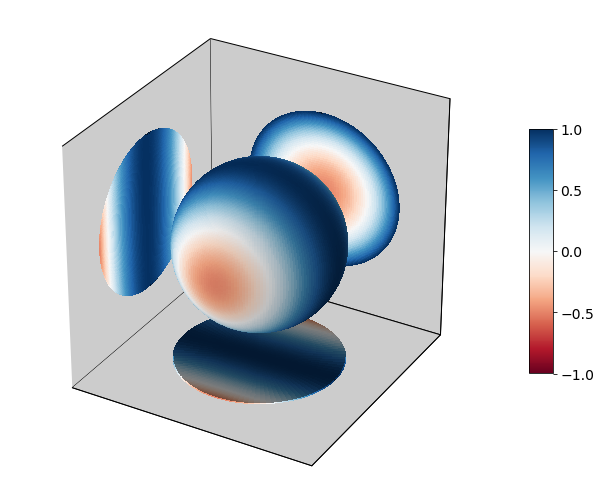

In [6]:
bell_tomo_set = tomo.state_tomography_set([0, 1])
bell_tomo_circuits = tomo.create_tomography_circuits(bell, qr, cr, bell_tomo_set)
bell_tomo_result = execute(bell_tomo_circuits, backend=backend, shots=shots).result()
bell_tomo_data = tomo.tomography_data(bell_tomo_result, 'Bell', bell_tomo_set)
rho_fit_sim = tomo.fit_tomography_data(bell_tomo_data)
plot_wigner_function(np.matrix(rho_fit_sim), res=200)

Again, using the same code from before, we can calculate the analytic expression for the Wigner function from the generated density matrix, it can be seen that since the density matrix is less sparse, the resulting Wigner function has many more terms

In [7]:
Delta_su2 = sym.zeros(2)   
Delta = sym.ones(1)
for qubit in range(num):
    phi = sym.Indexed('phi', qubit)
    theta = sym.Indexed('theta', qubit)
    costheta  = harr*sym.cos(2*theta)
    sintheta  = harr*sym.sin(2*theta)
    Delta_su2[0,0] =  (1+costheta)/2
    Delta_su2[0,1] = -(sym.exp(2j*phi)*sintheta)/2
    Delta_su2[1,0] = -(sym.exp(-2j*phi)*sintheta)/2
    Delta_su2[1,1] =  (1-costheta)/2
    Delta = TensorProduct(Delta,Delta_su2)
W = sym.trace(np.matrix(rho_fit_sim)*Delta)
print(sym.latex(W))

0.499936777529623 \left(- \frac{\sqrt{3} \cos{\left (2 {\theta}_{0} \right )}}{2} + \frac{1}{2}\right) \left(- \frac{\sqrt{3} \cos{\left (2 {\theta}_{1} \right )}}{2} + \frac{1}{2}\right) + 0.00184002904462755 \left(- \frac{\sqrt{3} \cos{\left (2 {\theta}_{0} \right )}}{2} + \frac{1}{2}\right) \left(\frac{\sqrt{3} \cos{\left (2 {\theta}_{1} \right )}}{2} + \frac{1}{2}\right) - \frac{\sqrt{3} \left(0.000646212815416196 - 0.00312198107705811 i\right) \left(- \frac{\sqrt{3} \cos{\left (2 {\theta}_{0} \right )}}{2} + \frac{1}{2}\right) e^{2.0 i {\phi}_{1}} \sin{\left (2 {\theta}_{1} \right )}}{2} - \frac{\sqrt{3} \left(0.000646212815416196 + 0.00312198107705811 i\right) \left(- \frac{\sqrt{3} \cos{\left (2 {\theta}_{0} \right )}}{2} + \frac{1}{2}\right) e^{- 2.0 i {\phi}_{1}} \sin{\left (2 {\theta}_{1} \right )}}{2} + 0.00184601514148403 \left(\frac{\sqrt{3} \cos{\left (2 {\theta}_{0} \right )}}{2} + \frac{1}{2}\right) \left(- \frac{\sqrt{3} \cos{\left (2 {\theta}_{1} \right )}}{2} + \frac

$W = 0.493698558640376 \left(- \frac{\sqrt{3}}{2} \cos{\left (2 \theta_{0} \right )} + \frac{1}{2}\right) \left(- \frac{\sqrt{3}}{2} \cos{\left (2 \theta_{1} \right )} + \frac{1}{2}\right) + 0.00275286172575906 \left(- \frac{\sqrt{3}}{2} \cos{\left (2 \theta_{0} \right )} + \frac{1}{2}\right) \left(\frac{\sqrt{3}}{2} \cos{\left (2 \theta_{1} \right )} + \frac{1}{2}\right) - \frac{\sqrt{3}}{2} \left(-0.00534735110770023 - 0.00770494561267218 i\right) \left(- \frac{\sqrt{3}}{2} \cos{\left (2 \theta_{0} \right )} + \frac{1}{2}\right) e^{2.0 i \phi_{1}} \sin{\left (2 \theta_{1} \right )} - \frac{\sqrt{3}}{2} \left(-0.00534735110770023 + 0.00770494561267218 i\right) \left(- \frac{\sqrt{3}}{2} \cos{\left (2 \theta_{0} \right )} + \frac{1}{2}\right) e^{- 2.0 i \phi_{1}} \sin{\left (2 \theta_{1} \right )} + 0.00266528247889166 \left(\frac{\sqrt{3}}{2} \cos{\left (2 \theta_{0} \right )} + \frac{1}{2}\right) \left(- \frac{\sqrt{3}}{2} \cos{\left (2 \theta_{1} \right )} + \frac{1}{2}\right) + 0.500883297154973 \left(\frac{\sqrt{3}}{2} \cos{\left (2 \theta_{0} \right )} + \frac{1}{2}\right) \left(\frac{\sqrt{3}}{2} \cos{\left (2 \theta_{1} \right )} + \frac{1}{2}\right) - \frac{\sqrt{3}}{2} \left(-0.0015149834996068 + 0.000102164609935808 i\right) \left(\frac{\sqrt{3}}{2} \cos{\left (2 \theta_{0} \right )} + \frac{1}{2}\right) e^{2.0 i \phi_{1}} \sin{\left (2 \theta_{1} \right )} - \frac{\sqrt{3}}{2} \left(-0.0015149834996068 - 0.000102164609935808 i\right) \left(\frac{\sqrt{3}}{2} \cos{\left (2 \theta_{0} \right )} + \frac{1}{2}\right) e^{- 2.0 i \phi_{1}} \sin{\left (2 \theta_{1} \right )} - \frac{\sqrt{3}}{2} \left(-0.00628509857352323 - 0.000924492486476053 i\right) \left(- \frac{\sqrt{3}}{2} \cos{\left (2 \theta_{1} \right )} + \frac{1}{2}\right) e^{2.0 i \phi_{0}} \sin{\left (2 \theta_{0} \right )} - \frac{\sqrt{3}}{2} \left(-0.00628509857352323 + 0.000924492486476053 i\right) \left(- \frac{\sqrt{3}}{2} \cos{\left (2 \theta_{1} \right )} + \frac{1}{2}\right) e^{- 2.0 i \phi_{0}} \sin{\left (2 \theta_{0} \right )} - \frac{\sqrt{3}}{2} \left(-0.000462681165102337 + 0.00867331154973143 i\right) \left(\frac{\sqrt{3}}{2} \cos{\left (2 \theta_{1} \right )} + \frac{1}{2}\right) e^{2.0 i \phi_{0}} \sin{\left (2 \theta_{0} \right )} - \frac{\sqrt{3}}{2} \left(-0.000462681165102337 - 0.00867331154973143 i\right) \left(\frac{\sqrt{3}}{2} \cos{\left (2 \theta_{1} \right )} + \frac{1}{2}\right) e^{- 2.0 i \phi_{0}} \sin{\left (2 \theta_{0} \right )} + \frac{3}{4} \left(0.492697839219187 - 0.0085595434721166 i\right) e^{2.0 i \phi_{0}} e^{2.0 i \phi_{1}} \sin{\left (2 \theta_{0} \right )} \sin{\left (2 \theta_{1} \right )} + \frac{3}{4} \left(0.00247818568149116 + 0.000867188901661959 i\right) e^{2.0 i \phi_{0}} e^{- 2.0 i \phi_{1}} \sin{\left (2 \theta_{0} \right )} \sin{\left (2 \theta_{1} \right )} + \frac{3}{4} \left(0.00247818568149116 - 0.000867188901661959 i\right) e^{- 2.0 i \phi_{0}} e^{2.0 i \phi_{1}} \sin{\left (2 \theta_{0} \right )} \sin{\left (2 \theta_{1} \right )} + \frac{3}{4} \left(0.492697839219187 + 0.0085595434721166 i\right) e^{- 2.0 i \phi_{0}} e^{- 2.0 i \phi_{1}} \sin{\left (2 \theta_{0} \right )} \sin{\left (2 \theta_{1} \right )}$

# Experiment

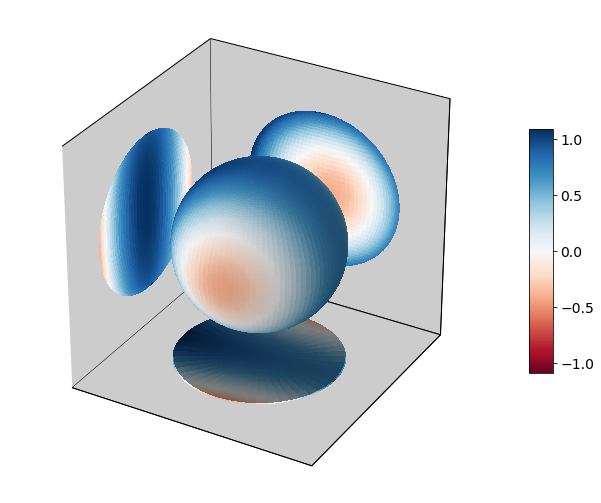

In [8]:
IBMQ.load_accounts()

backend = IBMQ.get_backend('ibmqx2')
max_credits = 8
shots = 1024
bell_qubits = [0, 1]
bell_tomo_set = tomo.state_tomography_set(bell_qubits)
bell_tomo_circuits = tomo.create_tomography_circuits(bell, qr, cr, bell_tomo_set)
bell_tomo_result = execute(bell_tomo_circuits, backend=backend, shots=shots, 
                           max_credits=max_credits).result()
bell_tomo_data = tomo.tomography_data(bell_tomo_result, 'Bell', bell_tomo_set)
rho_fit_ibmqx = tomo.fit_tomography_data(bell_tomo_data)
plot_wigner_function(np.matrix(rho_fit_ibmqx), res=100)

In [9]:
print(rho_fit_ibmqx)

[[0.48153775+0.j         0.04986367-0.02071181j 0.05420926-0.01399036j
  0.42550767+0.00541452j]
 [0.04986367+0.02071181j 0.02967715+0.j         0.01582514-0.00135436j
  0.05000208+0.00902968j]
 [0.05420926+0.01399036j 0.01582514+0.00135436j 0.04391773+0.j
  0.05013479-0.00670961j]
 [0.42550767-0.00541452j 0.05000208-0.00902968j 0.05013479+0.00670961j
  0.44486737+0.j        ]]


In [10]:
Delta_su2 = sym.zeros(2)   
Delta = sym.ones(1)
for qubit in range(num):
    phi = sym.Indexed('phi', qubit)
    theta = sym.Indexed('theta', qubit)
    costheta  = harr*sym.cos(2*theta)
    sintheta  = harr*sym.sin(2*theta)
    Delta_su2[0,0] =  (1+costheta)/2
    Delta_su2[0,1] = -(sym.exp(2j*phi)*sintheta)/2
    Delta_su2[1,0] = -(sym.exp(-2j*phi)*sintheta)/2
    Delta_su2[1,1] =  (1-costheta)/2
    Delta = TensorProduct(Delta,Delta_su2)
W = sym.trace(np.matrix(rho_fit_ibmqx)*Delta)
print(sym.latex(W))

0.444867367250469 \left(- \frac{\sqrt{3} \cos{\left (2 {\theta}_{0} \right )}}{2} + \frac{1}{2}\right) \left(- \frac{\sqrt{3} \cos{\left (2 {\theta}_{1} \right )}}{2} + \frac{1}{2}\right) + 0.043917727243482 \left(- \frac{\sqrt{3} \cos{\left (2 {\theta}_{0} \right )}}{2} + \frac{1}{2}\right) \left(\frac{\sqrt{3} \cos{\left (2 {\theta}_{1} \right )}}{2} + \frac{1}{2}\right) - \frac{\sqrt{3} \left(0.0501347850838195 + 0.00670960560900125 i\right) \left(- \frac{\sqrt{3} \cos{\left (2 {\theta}_{0} \right )}}{2} + \frac{1}{2}\right) e^{2.0 i {\phi}_{1}} \sin{\left (2 {\theta}_{1} \right )}}{2} - \frac{\sqrt{3} \left(0.0501347850838195 - 0.00670960560900125 i\right) \left(- \frac{\sqrt{3} \cos{\left (2 {\theta}_{0} \right )}}{2} + \frac{1}{2}\right) e^{- 2.0 i {\phi}_{1}} \sin{\left (2 {\theta}_{1} \right )}}{2} + 0.0296771540842934 \left(\frac{\sqrt{3} \cos{\left (2 {\theta}_{0} \right )}}{2} + \frac{1}{2}\right) \left(- \frac{\sqrt{3} \cos{\left (2 {\theta}_{1} \right )}}{2} + \frac{1}{2}\

$0.32699519833677 \left(- \frac{\sqrt{3}}{2} \cos{\left (2 \theta_{0} \right )} + \frac{1}{2}\right) \left(- \frac{\sqrt{3}}{2} \cos{\left (2 \theta_{1} \right )} + \frac{1}{2}\right) + 0.124306773174647 \left(- \frac{\sqrt{3}}{2} \cos{\left (2 \theta_{0} \right )} + \frac{1}{2}\right) \left(\frac{\sqrt{3}}{2} \cos{\left (2 \theta_{1} \right )} + \frac{1}{2}\right) - \frac{\sqrt{3}}{2} \left(0.0285310304913017 + 0.0238741788035984 i\right) \left(- \frac{\sqrt{3}}{2} \cos{\left (2 \theta_{0} \right )} + \frac{1}{2}\right) e^{2.0 i \phi_{1}} \sin{\left (2 \theta_{1} \right )} - \frac{\sqrt{3}}{2} \left(0.0285310304913017 - 0.0238741788035984 i\right) \left(- \frac{\sqrt{3}}{2} \cos{\left (2 \theta_{0} \right )} + \frac{1}{2}\right) e^{- 2.0 i \phi_{1}} \sin{\left (2 \theta_{1} \right )} + 0.124202902962916 \left(\frac{\sqrt{3}}{2} \cos{\left (2 \theta_{0} \right )} + \frac{1}{2}\right) \left(- \frac{\sqrt{3}}{2} \cos{\left (2 \theta_{1} \right )} + \frac{1}{2}\right) + 0.424495125525667 \left(\frac{\sqrt{3}}{2} \cos{\left (2 \theta_{0} \right )} + \frac{1}{2}\right) \left(\frac{\sqrt{3}}{2} \cos{\left (2 \theta_{1} \right )} + \frac{1}{2}\right) - \frac{\sqrt{3}}{2} \left(0.0490359773360699 + 0.0381005337507329 i\right) \left(\frac{\sqrt{3}}{2} \cos{\left (2 \theta_{0} \right )} + \frac{1}{2}\right) e^{2.0 i \phi_{1}} \sin{\left (2 \theta_{1} \right )} - \frac{\sqrt{3}}{2} \left(0.0490359773360699 - 0.0381005337507329 i\right) \left(\frac{\sqrt{3}}{2} \cos{\left (2 \theta_{0} \right )} + \frac{1}{2}\right) e^{- 2.0 i \phi_{1}} \sin{\left (2 \theta_{1} \right )} - \frac{\sqrt{3}}{2} \left(0.0512856636758563 + 0.0414367583959388 i\right) \left(- \frac{\sqrt{3}}{2} \cos{\left (2 \theta_{1} \right )} + \frac{1}{2}\right) e^{2.0 i \phi_{0}} \sin{\left (2 \theta_{0} \right )} - \frac{\sqrt{3}}{2} \left(0.0512856636758563 - 0.0414367583959388 i\right) \left(- \frac{\sqrt{3}}{2} \cos{\left (2 \theta_{1} \right )} + \frac{1}{2}\right) e^{- 2.0 i \phi_{0}} \sin{\left (2 \theta_{0} \right )} - \frac{\sqrt{3}}{2} \left(0.0408691303527403 + 0.0280408874045363 i\right) \left(\frac{\sqrt{3}}{2} \cos{\left (2 \theta_{1} \right )} + \frac{1}{2}\right) e^{2.0 i \phi_{0}} \sin{\left (2 \theta_{0} \right )} - \frac{\sqrt{3}}{2} \left(0.0408691303527403 - 0.0280408874045363 i\right) \left(\frac{\sqrt{3}}{2} \cos{\left (2 \theta_{1} \right )} + \frac{1}{2}\right) e^{- 2.0 i \phi_{0}} \sin{\left (2 \theta_{0} \right )} + \frac{3}{4} \left(0.285095302985003 - 0.00922257353994807 i\right) e^{2.0 i \phi_{0}} e^{2.0 i \phi_{1}} \sin{\left (2 \theta_{0} \right )} \sin{\left (2 \theta_{1} \right )} + \frac{3}{4} \left(-0.035281529513114 - 0.00875077955598942 i\right) e^{2.0 i \phi_{0}} e^{- 2.0 i \phi_{1}} \sin{\left (2 \theta_{0} \right )} \sin{\left (2 \theta_{1} \right )} + \frac{3}{4} \left(-0.035281529513114 + 0.00875077955598942 i\right) e^{- 2.0 i \phi_{0}} e^{2.0 i \phi_{1}} \sin{\left (2 \theta_{0} \right )} \sin{\left (2 \theta_{1} \right )} + \frac{3}{4} \left(0.285095302985003 + 0.00922257353994807 i\right) e^{- 2.0 i \phi_{0}} e^{- 2.0 i \phi_{1}} \sin{\left (2 \theta_{0} \right )} \sin{\left (2 \theta_{1} \right )}$

# Measuring Points in Phase Space

We will now look at how to create the circuits to measure set points in phase space. The following results are based on the figures in [*RP Rundle, PW Mills, T Tilma, JH Samson, MJ Everitt, Phys. Rev. A 96, 022117*](r p rundle prl)

## Plaquette Visualisation
Staying with the bell state, we will look here at the slice where $\phi_0=\phi_1=0$ and we plot $\theta_0$ against $\theta_1$

In [11]:
theta1_points = 8
theta2_points = 8
number_of_points = theta1_points*theta2_points
the1 = [0]*number_of_points
the2 = [0]*number_of_points #initialize theta values
phis = [[0]*number_of_points]*number_of_qubits #set phi values to 0

point = 0
for i in range(theta1_points):
    for k in range(theta2_points):
        
        the1[point] = 2*i*np.pi/theta1_points
        the2[point] = 2*k*np.pi/theta2_points #create the values of theta for all points on plot
        point += 1
        
thetas = np.vstack((the1,the2))
bell_circuits = tomo.build_wigner_circuits(bell, phis, thetas, 
                                           bell_qubits, qr, cr)

backend = Aer.get_backend('qasm_simulator')
shots = 1024
bell_result = execute(bell_circuits, backend=backend, shots=shots).result()
print(bell_result.status)

COMPLETED


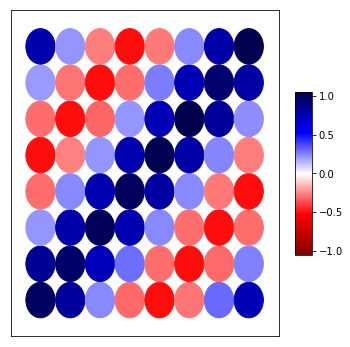

In [12]:
wdata = tomo.wigner_data(bell_result, bell_qubits,
                        bell_circuits, shots=shots)
wdata = np.matrix(wdata)
wdata = wdata.reshape(theta1_points,theta2_points) 
plot_wigner_data(wdata, method='plaquette')

## Curve on a Wigner fucntion
We can also take a line around phase space and plot a curve. A useful line to take is the equator of the equal angle slice, below we plot this slice also for the Bell-state. When we have an $n$-qubit maximally entangled state of the form $\left(|0...0\rangle + |1...1\rangle\right)/\sqrt{2}$, the equatorial slice will show sinusoidal behaviour with frequency $n$.

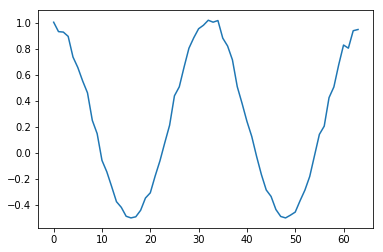

In [13]:
equator_points = 64
theta = [np.pi/2]*equator_points
phi = [0]*equator_points

point = 0
for i in range(equator_points):
    phi[i] = 2*i*np.pi/equator_points
        
thetas = np.vstack((theta,theta))
phis = np.vstack((phi,phi))
bell_eq_circuits = tomo.build_wigner_circuits(bell, phis, thetas, 
                                              bell_qubits, qr, cr)
bell_eq_result = execute(bell_eq_circuits, backend=backend, shots=shots).result()
wdata_eq = tomo.wigner_data(bell_eq_result,  bell_qubits,
                        bell_eq_circuits, shots=shots)
plot_wigner_data(wdata_eq, method='curve')

Recreating the equatorial slice of a five qubit GHZ state, $\left(|00000\rangle - |11111\rangle\right)/\sqrt{2}$ from the paper, the following gates are needed...

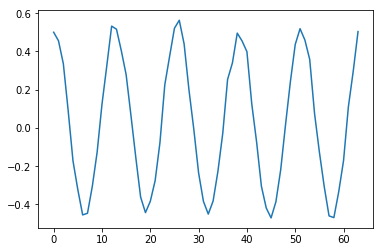

In [14]:
number_of_qubits = 5
backend = Aer.get_backend('qasm_simulator')
shots = 1024
ghz_qubits = [0, 1, 2, 3, 4]
qr = QuantumRegister(5, name='qr')
cr = ClassicalRegister(5, name='cr')
ghz = QuantumCircuit(qr, cr, name='ghz')
ghz.h(qr[0])
ghz.h(qr[1])
ghz.x(qr[2])
ghz.h(qr[3])
ghz.h(qr[4])
ghz.cx(qr[0],qr[2])
ghz.cx(qr[1],qr[2])
ghz.cx(qr[3],qr[2])
ghz.cx(qr[4],qr[2])
ghz.h(qr[0])
ghz.h(qr[1])
ghz.h(qr[2])
ghz.h(qr[3])
ghz.h(qr[4])

equator_points = 64
thetas = [[np.pi/2]*equator_points]*number_of_qubits
phi = [0]*equator_points

point = 0
for i in range(equator_points):
    phi[i] = 2*i*np.pi/equator_points
phis = np.vstack((phi,phi,phi,phi,phi))
ghz_eq_circuits = tomo.build_wigner_circuits(ghz, phis, thetas, 
                                             ghz_qubits, qr, cr)
ghz_eq_result = execute(ghz_eq_circuits, backend=backend, shots=shots).result()
wghzdata_eq = tomo.wigner_data(ghz_eq_result, ghz_qubits,
                               ghz_eq_circuits, shots=shots)
plot_wigner_data(wghzdata_eq, method='curve')

Since all the data for the plot is stored within `wghzdata_eq`, we can import matplotlib and go wild with different ways of plotting

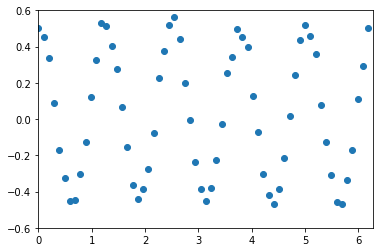

In [15]:
import matplotlib.pyplot as plt
plt.plot(phi, wghzdata_eq, 'o')
plt.axis([0, 2*np.pi, -0.6, 0.6])
plt.show()

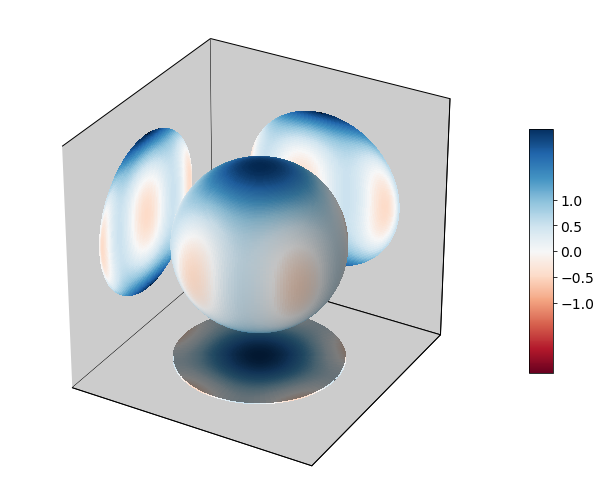

In [16]:
density_matrix = np.zeros((32,32))
density_matrix[0][0] = 0.5
density_matrix[0][31] = -0.5
density_matrix[31][0] = -0.5
density_matrix[31][31] = 0.5
plot_wigner_function(density_matrix, res=200)